In [4]:
import pandas as pd
import numpy as np
import sys, os
import seaborn as sns
from scipy.stats import hypergeom
from sklearn.metrics import normalized_mutual_info_score
from topicpy.hsbmpy import get_max_available_L, get_scores, add_score_lines
import matplotlib.pyplot as plt
import multiprocessing as mp
from time import time
import logging
log = logging.getLogger()

In [5]:
population=pd.read_csv("https://stephenslab.github.io/count-clustering/project/utilities/gene_names_all_gtex.txt", header=None).values.ravel()

In [6]:
df_files = pd.read_csv("https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", sep='\t').loc[:,['SAMPID','SMTS', 'SMTSD']]
df_files.set_index('SAMPID', inplace=True)

In [7]:
palette = sns.diverging_palette(240, 10, sep=20, as_cmap=True)

In [8]:
work_dir = "/home/jovyan/work/phd/topics/datasets/"

In [9]:
experiments = ["gtex10", "gtexhk", "random/random00", "random/random11", "random/random22", "random/random33", "random/random44", "random/random55", "random/random66", "random/random77", "random/random88", "random/random99"]
#experiments = ["gtex10","gtexall","gtexhk","random/random11"]
genes = []
for directory in experiments:
    genes.append(pd.read_csv(f"{work_dir}/{directory}/mainTable.csv", index_col=0).index)

In [ ]:
def get_pval(setA, setB):
    x = setA.isin(setB).sum() # number of successes
    M = len(population) # pop size
    k = len(setB) # successes in pop
    N = len(setA) # sample size
    pval = hypergeom.sf(x-1, M, k, N)
    return pval
#-np.log10(get_pval(setA, setB)+1)

In [ ]:
overlaps = list(map(lambda setA: list(map(lambda setB: setA.isin(setB).sum()/float(len(setA)), genes)), genes))

In [ ]:
cm = sns.clustermap(
    overlaps, 
    row_cluster=False,
    col_cluster=False, 
    vmin=0,
    vmax=max(list(map(lambda x: max(filter(lambda xi: xi<1,x)), overlaps)))
)

ax = cm.ax_heatmap
ax.yaxis.set_label_position("left")
ax.yaxis.tick_left()
ax.set_ylabel("Sets", fontsize=35)
ax.set_xlabel("Sets", fontsize=35)
ax.set_xticklabels(experiments, rotation=45)
ax.set_yticklabels(experiments, rotation=0)

ax.tick_params(labelsize=30)


bax = cm.ax_cbar
bax.tick_params(labelsize=25)
bax.set_title("% overlap", fontsize=35)

plt.show()
cm.savefig("selection_overlap.pdf")

In [ ]:
algorithm = "topsbm"

In [ ]:
def get_scores_mp(directory):
    return directory, get_scores(work_dir+directory, ["SMTS"], algorithm=algorithm, df_files=df_files)["SMTS"]

def get_scores_clbck(packed_score):
    global scores
    scores[packed_score[0]]=packed_score[1]

In [ ]:
scores = {}
        
start = time()
    
pool = mp.Pool(12)

work = [pool.apply_async(get_scores_mp, args=([directory]), callback=get_scores_clbck, error_callback=lambda err:print(err)) for directory in experiments]

pool.close()
pool.join()

print(time()-start)

In [ ]:
fig, ax = plt.subplots(figsize=(18,15))
add_score_lines(ax, scores, labels = experiments)
ax.set_title(algorithm, fontsize=30)
ax.set_xlim(1,800)
fig.savefig(f"scores_selections_{algorithm}.pdf")

In [ ]:
def get_exp_labels(experiment):
    global files
    #print(experiment)
    levels = {
        "gtex10":{
            "topsbm": 2,
            "topsbm-log": 2,
            "lda": 3,
            "tm":0,
            "wgcna":0
        },
        "gtexhk":{
            "topsbm": 1,
            "lda": 1,
            "tm":0,
            "wgcna":0
        }
    }
    if experiment in levels.keys():
        level = levels[experiment][algorithm]
    else:
        level = get_max_available_L(work_dir+experiment, algorithm)-1
    df_clusters = pd.read_csv(f"{work_dir}/{experiment}/{algorithm}/{algorithm}_level_{level}_clusters.csv")
    exp_data = []
    new_idx = files.index[files.index.isin(df_clusters.values.ravel())]
    for file in new_idx:
        exp_data.append(df_clusters.columns[df_clusters[df_clusters==file].any(0)].values[0].split(" ")[1])
    return pd.Series(name=experiment, data=exp_data, index = new_idx)

def exp_clbck(exp_series):
    global files
    files = files.join(exp_series, how="outer")

In [ ]:
experiments = ["gtex10", "gtexhk", "random/random00", "random/random11", "random/random22", "random/random33", "random/random44", "random/random55", "random/random66", "random/random77", "random/random88", "random/random99"]
#experiments = ["gtex10", "gtexhk", "random/random11", "random/random22", "random/random33"]

In [ ]:
files = pd.DataFrame(index=df_files.index)
scores = {}
        
start = time()
    
pool = mp.Pool(12)

work = [pool.apply_async(get_exp_labels, args=([directory]), callback=exp_clbck, error_callback=lambda err:print(err)) for directory in experiments]

pool.close()
pool.join()

print(time()-start)

In [ ]:
files.astype(float).apply(np.nanmax,0).astype(int)

In [ ]:
partitions = files.transpose().values

In [ ]:
def score(A, B):
    mask = ~(np.isnan(A.astype(float)) | np.isnan(B.astype(float))) #demorgan law
    return normalized_mutual_info_score(A[mask], B[mask])

partition_overlap = list(map(lambda partitionA: list(map(lambda partitionB: score(partitionA, partitionB), partitions)), partitions))

In [ ]:
cm = sns.clustermap(
    partition_overlap, 
    row_cluster=False,
    col_cluster=False,
    vmin=0.0,
    cmap=palette
)

ax = cm.ax_heatmap
ax.set_title(algorithm, fontsize=35)
ax.yaxis.set_label_position("left")
ax.yaxis.tick_left()
ax.set_ylabel("Clusters sets", fontsize=35)
ax.set_xlabel("Clusters sets", fontsize=35)
ax.tick_params(labelsize=30)
ax.set_xticklabels(experiments, rotation=45)
ax.set_yticklabels(experiments, rotation=0)

bax = cm.ax_cbar
bax.tick_params(labelsize=25)
bax.set_title("NMI", fontsize=35)

plt.show()
cm.savefig(f"cluster_overlap_{algorithm}.pdf")

# Compare algorithms

## topics

In [ ]:
def get_exp_topic_labels(algorithm, experiment):
    global files_topic
    #print(experiment)
    levels = {
        "gtex10":{
            "topsbm": 3,
            "topsbm-log": 2,
            "lda": 2,
            "tm":0,
            "wgcna":0
        },
        "random/random11":{
            "topsbm": 1,
            "topsbm-log": 1,
            "lda": 2,
            "tm":0,
            "wgcna":0
        },
        "random/random22":{
            "topsbm": 2,
            "topsbm-log": 1,
            "lda": 1,
            "tm":0,
            "wgcna":0
        },
        "gtexhk":{
            "topsbm": 2,
            "lda": 1,
            "tm":0,
            "wgcna":0
        }
    }
    level = levels[experiment][algorithm]
    df_topics = pd.read_csv(f"{work_dir}/{experiment}/{algorithm}/{algorithm}_level_{level}_topics.csv")
    exp_data = []
    new_idx = files_topic.index[files_topic.index.isin(df_topics.values.ravel())]
    df_topics.columns = np.unique(df_topics.columns, return_inverse=True)[1]
    for file in new_idx:
        exp_data.append(df_topics.columns[df_topics[df_topics==file].any(0)].values[0])
    return pd.Series(name=algorithm, data=exp_data, index = new_idx)

def exp_topic_clbck(exp_series):
    global files_topic
    files_topic = files_topic.join(exp_series, how="outer")

In [ ]:
algorithms = ["topsbm", "topsbm-log", "lda", "tm", "wgcna"]
experiment = experiments[4]

In [ ]:
files_topic = pd.DataFrame(index=population)
scores = {}
        
start = time()
    
pool = mp.Pool(6)

work = [pool.apply_async(get_exp_topic_labels, args=([alg, experiment]), callback=exp_topic_clbck, error_callback=lambda err:print(err)) for alg in algorithms]

pool.close()
pool.join()

print(time()-start)

In [ ]:
files_topic.max(axis=0).astype(int)

In [ ]:
partitions_topics = files_topic.transpose().values

In [ ]:
def score(A, B):
    mask = ~(np.isnan(A.astype(float)) | np.isnan(B.astype(float))) #demorgan law
    return normalized_mutual_info_score(A[mask], B[mask])
    
partition_topics_overlap = list(map(lambda partitionA: list(map(lambda partitionB: score(partitionA, partitionB), partitions_topics)), partitions_topics))

In [ ]:
cm = sns.clustermap(
    partition_topics_overlap, 
    row_cluster=False,
    col_cluster=False,
    vmin=0.0,
    cmap = palette
)

ax = cm.ax_heatmap
ax.set_title(experiment, fontsize=35)
ax.yaxis.set_label_position("left")
ax.yaxis.tick_left()
ax.set_ylabel("Topics", fontsize=35)
ax.set_xlabel("Topics", fontsize=35)
ax.tick_params(labelsize=30)
ax.set_xticklabels(files_topic.columns, rotation=45)
ax.set_yticklabels(files_topic.columns, rotation=0)

bax = cm.ax_cbar
bax.tick_params(labelsize=25)
bax.set_title("NMI", fontsize=35)

plt.show()
cm.savefig(f"topic_overlap_{experiment}.pdf")

## clusters

In [ ]:
def get_exp_cluster_labels(algorithm, experiment):
    global files_topic
    #print(experiment)
    levels = {
        "topsbm": 1,
        "topsbm-log":1,
        "lda": 1,
        "tm":0,
        "wgcna":1
    }
    #level = get_max_available_L(work_dir+experiment, algorithm)
    level = levels[algorithm]
    df_clusters = pd.read_csv(f"{work_dir}/{experiment}/{algorithm}/{algorithm}_level_{level}_clusters.csv")
    exp_data = []
    new_idx = files_cluster.index[files_cluster.index.isin(df_clusters.values.ravel())]
    df_clusters.columns = np.unique(df_clusters.columns, return_inverse=True)[1]
    for file in new_idx:
        exp_data.append(df_clusters.columns[df_clusters[df_clusters==file].any(0)].values[0])
    return pd.Series(name=algorithm, data=exp_data, index = new_idx)

def exp_topic_clbck(exp_series):
    global files_cluster
    files_cluster = files_cluster.join(exp_series, how="outer")

In [ ]:
files_cluster = pd.DataFrame(index=df_files.index)
scores = {}
        
start = time()
    
pool = mp.Pool(4)

work = [pool.apply_async(get_exp_cluster_labels, args=([alg, experiment]), callback=exp_topic_clbck, error_callback=lambda err:print(err)) for alg in algorithms]

pool.close()
pool.join()

print(time()-start)

In [ ]:
files_cluster.max(axis=0).astype(int)

In [ ]:
partitions_clusters = files_cluster.transpose().values

In [ ]:
partition_clusters_overlap = list(map(lambda partitionA: list(map(lambda partitionB: score(partitionA, partitionB), partitions_clusters)), partitions_clusters))

In [ ]:
cm = sns.clustermap(
    partition_clusters_overlap, 
    row_cluster=False,
    col_cluster=False,
    vmin=0.0,
    cmap = palette
)

ax = cm.ax_heatmap
ax.set_title(experiment, fontsize=35)
ax.yaxis.set_label_position("left")
ax.yaxis.tick_left()
ax.set_ylabel("Clusters", fontsize=35)
ax.set_xlabel("Clusters", fontsize=35)
ax.tick_params(labelsize=30)
ax.set_xticklabels(files_cluster.columns, rotation=45)
ax.set_yticklabels(files_cluster.columns, rotation=0)

bax = cm.ax_cbar
bax.tick_params(labelsize=25)
bax.set_title("NMI", fontsize=35)

plt.show()
cm.savefig(f"cluster_overlap_{experiment}.pdf")

## Stable genes

In [1]:
def get_topic(algorithm, experiment):
    levels = {
        "gtex10":{
            "topsbm": 3,
            "topsbm-log": 2,
            "lda": 2,
            "tm":0,
            "wgcna":0
        },
        "random/random11":{
            "topsbm": 1,
            "topsbm-log": 1,
            "lda": 2,
            "tm":0,
            "wgcna":0
        },
        "random/random22":{
            "topsbm": 2,
            "topsbm-log": 1,
            "lda": 1,
            "tm":0,
            "wgcna":0
        },
        "gtexhk":{
            "topsbm": 2,
            "lda": 1,
            "tm":0,
            "wgcna":0
        }
    }
    level = levels[experiment][algorithm]
    df_topics = pd.read_csv(f"{work_dir}/{experiment}/{algorithm}/{algorithm}_level_{level}_topics.csv")
    for topic in df_topics.columns:
        yield df_topics[topic].dropna().values

In [10]:
genes = pd.read_csv("http://stephenslab.github.io/count-clustering/project/utilities/gene_names_all_gtex.txt", header=None, index_col=0)
genes["idx"]=list(range(genes.shape[0]))
genes.at["ENSG00000000419","idx"]

0

In [62]:
import networkx as nx
import graph_tool.all as gt

In [106]:
G = gt.Graph()
name = G.vp["name"] = G.new_vertex_property("string")

In [107]:
for gene in genes["idx"].items():
    v = G.add_vertex()
    assert(v==gene[1])
    name[v]=gene[0]

In [108]:
for algorithm in ["topsbm", "lda", "tm", "wgcna"]:
    print(algorithm)
    topic_gen = get_topic(algorithm,"gtex10")
    for topic_genes in topic_gen:
        for ig1, g1 in enumerate(topic_genes):
            G.add_edge_list(((genes.at[g1,"idx"],genes.at[g2,"idx"]) for g2 in topic_genes[ig1:]))

topsbm
lda
tm
wgcna


In [89]:
filter_degree = G.new_vertex_property("bool")
for v in G.vertices():
    filter_degree[v] = len(G.get_all_neighbors(v)) > 1
    
G.set_vertex_filter(filter_degree)
G.purge_vertices()
G.clear_filters()
G

<Graph object, directed, with 982 vertices and 646047 edges, 1 internal vertex property, at 0x7f4bb0f3db20>

In [109]:
adjacency = gt.adjacency(G).toarray()

In [115]:
adjacency.max()

10.0

In [131]:
g = nx.Graph()
for irow, row in enumerate(adjacency):
    for icol, w in enumerate(row):
        if w > 5:
            g.add_edge(irow, icol, weight=w)

In [52]:
g=nx.Graph()
g.add_node("pippo")
g.add_node("pluto")
g.add_node("paperino")
for e in [("pippo","pluto"),("pippo","paperino"),("pippo","paperino"),("paperino","pluto")]:
    g.add_edge(*e, weight=10)

In [60]:
[e for e in G.edges(data=True)]

[('pippo', 'pluto', {'weight': 10}),
 ('pippo', 'paperino', {'weight': 10}),
 ('pluto', 'paperino', {'weight': 10})]

In [93]:
nx.draw(g)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f4b1d72f040> (for post_execute):


KeyboardInterrupt: 

In [15]:
import seaborn as sns

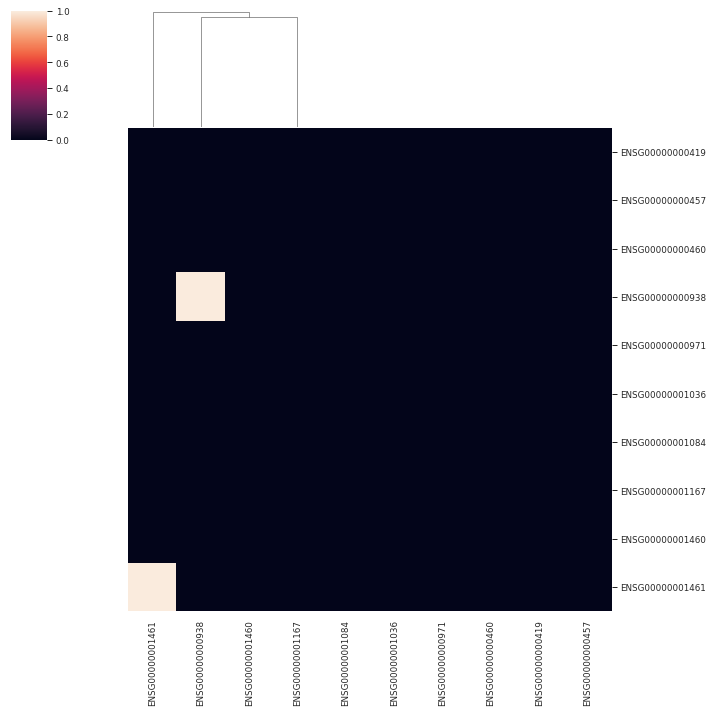

In [16]:
sns.clustermap(nx.adjacency_matrix(G).toarray()[:10,:10],
              xticklabels=genes.index,
              yticklabels=genes.index,
              row_cluster=False)

[python-louvain](https://python-louvain.readthedocs.io/en/latest/api.html)

In [117]:
import community as community_louvain

In [132]:
partition = community_louvain.best_partition(g)

In [133]:
df_partition = pd.DataFrame(data=partition.items(), columns=["ensg", "partition"])
df_partition.groupby("partition").count().sort_values("ensg", ascending=False)

,ensg
partition,
14,53
1,49
4,32
24,30
25,18
...,...
43,1
42,1
41,1


In [135]:
for g in df_partition[df_partition["partition"]==4]["ensg"].values:
    print(genes[genes["idx"]==g].index[0])

ENSG00000132698
ENSG00000176153
ENSG00000081277
ENSG00000088002
ENSG00000092295
ENSG00000108352
ENSG00000133710
ENSG00000143556
ENSG00000150782
ENSG00000174564
ENSG00000178363
ENSG00000184363
ENSG00000196754
ENSG00000096696
ENSG00000101213
ENSG00000108602
ENSG00000110400
ENSG00000134317
ENSG00000163141
ENSG00000163472
ENSG00000172382
ENSG00000197191
ENSG00000170545
ENSG00000106258
ENSG00000116990
ENSG00000167600
ENSG00000181652
ENSG00000184163
ENSG00000223573
ENSG00000255769
ENSG00000186806
ENSG00000234964


In [138]:
df_partition.to_csv("partitions.csv")

In [137]:
df_partition["gene"]=[genes[genes["idx"]==g].index[0] for g in df_partition["ensg"]]